In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import neurokit2 as nk

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from hmmlearn import hmm

In [2]:
thmm_to_results = pd.read_csv('../results-to-thmm.csv')
thmm_to_results.head()

,Feature Type,Window Size,Step Size,Components Slow,Mixtures Slow,Components Fast,Mixtures Fast,Covariance Type,Mean Accuracy,Standard Deviation,Max Accuracy,Min Accuracy,True Positives,False Positives,True Negatives,False Negatives,Precision,Recall,F1 Score
0,Relevant Features,3s,3s,1,1,1,1,full,0.563646,0.024668,0.609375,0.489583,43.0,53.0,74.0,22.0,0.447917,0.661538,0.534161
1,Relevant Features,3s,3s,1,1,1,1,diag,0.577396,0.030146,0.671875,0.515625,58.0,38.0,71.0,25.0,0.604167,0.698795,0.648045
2,Relevant Features,3s,3s,1,1,1,1,spherical,0.496354,0.034149,0.583333,0.421875,41.0,55.0,71.0,25.0,0.427083,0.621212,0.506173
3,Relevant Features,3s,3s,1,1,1,2,full,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Relevant Features,3s,3s,1,1,1,2,diag,0.501823,0.011252,0.572917,0.479167,89.0,7.0,21.0,75.0,0.927083,0.542683,0.684615


In [3]:
top_10 = thmm_to_results.sort_values("Max Accuracy", ascending=False).head(10)
top_10.reset_index(drop=True, inplace=True)
top_10["Window Size"] = pd.to_timedelta(top_10["Window Size"]).dt.total_seconds()
top_10["Step Size"] = pd.to_timedelta(top_10["Step Size"]).dt.total_seconds()
top_10["Covariance Type"] = top_10["Covariance Type"].replace({"diag": "Diagonal", "full": "Full", "spherical": "Spherical"})
top_10

,Feature Type,Window Size,Step Size,Components Slow,Mixtures Slow,Components Fast,Mixtures Fast,Covariance Type,Mean Accuracy,Standard Deviation,Max Accuracy,Min Accuracy,True Positives,False Positives,True Negatives,False Negatives,Precision,Recall,F1 Score
0,Relevant Features,0.1,0.05,1,1,1,1,Full,0.674583,0.030949,0.755208,0.593750,71.0,25.0,74.0,22.0,0.739583,0.763441,0.751323
1,Relevant Features,0.1,0.10,1,1,1,1,Diagonal,0.687240,0.030578,0.755208,0.609375,65.0,31.0,80.0,16.0,0.677083,0.802469,0.734463
2,Relevant Features,0.1,0.05,1,1,1,1,Diagonal,0.685417,0.026301,0.750000,0.619792,65.0,31.0,79.0,17.0,0.677083,0.792683,0.730337
3,Relevant Features,0.5,0.10,1,1,1,1,Diagonal,0.682240,0.030490,0.744792,0.604167,57.0,39.0,86.0,10.0,0.593750,0.850746,0.699387
4,Relevant Features,0.5,0.50,1,1,1,1,Diagonal,0.670052,0.025360,0.744792,0.598958,62.0,34.0,81.0,15.0,0.645833,0.805195,0.716763
5,Relevant Features,1.0,1.00,1,1,1,1,Full,0.649635,0.033071,0.739583,0.583333,57.0,39.0,85.0,11.0,0.593750,0.838235,0.695122
6,Relevant Features,0.1,0.10,1,1,1,1,Full,0.677396,0.026258,0.739583,0.619792,67.0,29.0,75.0,21.0,0.697917,0.761364,0.728261
7,Relevant Features,1.0,0.50,1,1,1,1,Diagonal,0.666198,0.029766,0.734375,0.598958,58.0,38.0,83.0,13.0,0.604167,0.816901,0.694611
8,Relevant Features,0.5,0.50,1,1,1,1,Full,0.669375,0.028274,0.734375,0.598958,60.0,36.0,81.0,15.0,0.625000,0.800000,0.701754
9,Relevant Features,1.0,1.00,1,1,1,1,Diagonal,0.666042,0.031096,0.734375,0.583333,59.0,37.0,82.0,14.0,0.614583,0.808219,0.698225


In [4]:
top_10.to_csv("thmm-to-top-10.csv", index=False)

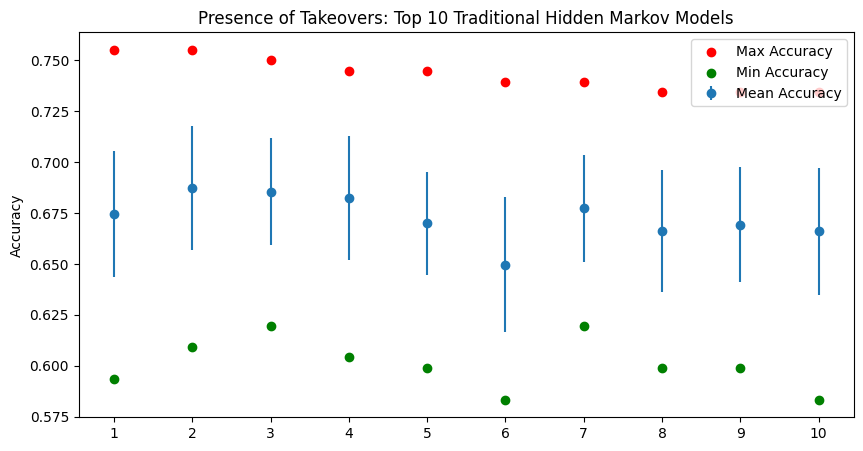

In [5]:
# Plot mean accuracy, std deviation, and max accuracy for the top 10 models
std = top_10["Standard Deviation"]
mean = top_10["Mean Accuracy"]
max_acc = top_10["Max Accuracy"]
min_acc = top_10["Min Accuracy"]
model = top_10.index+1

plt.figure(figsize=(10, 5))
plt.errorbar(model, mean, yerr=std, fmt='o', label="Mean Accuracy")
plt.scatter(model, max_acc, color='red', label="Max Accuracy")
plt.scatter(model, min_acc, color='green', label="Min Accuracy")
plt.xticks(model)
plt.xlabel("")
plt.ylabel("Accuracy")
plt.title("Presence of Takeovers: Top 10 Traditional Hidden Markov Models")
plt.legend()
plt.show()

hyperparameter optimization ^

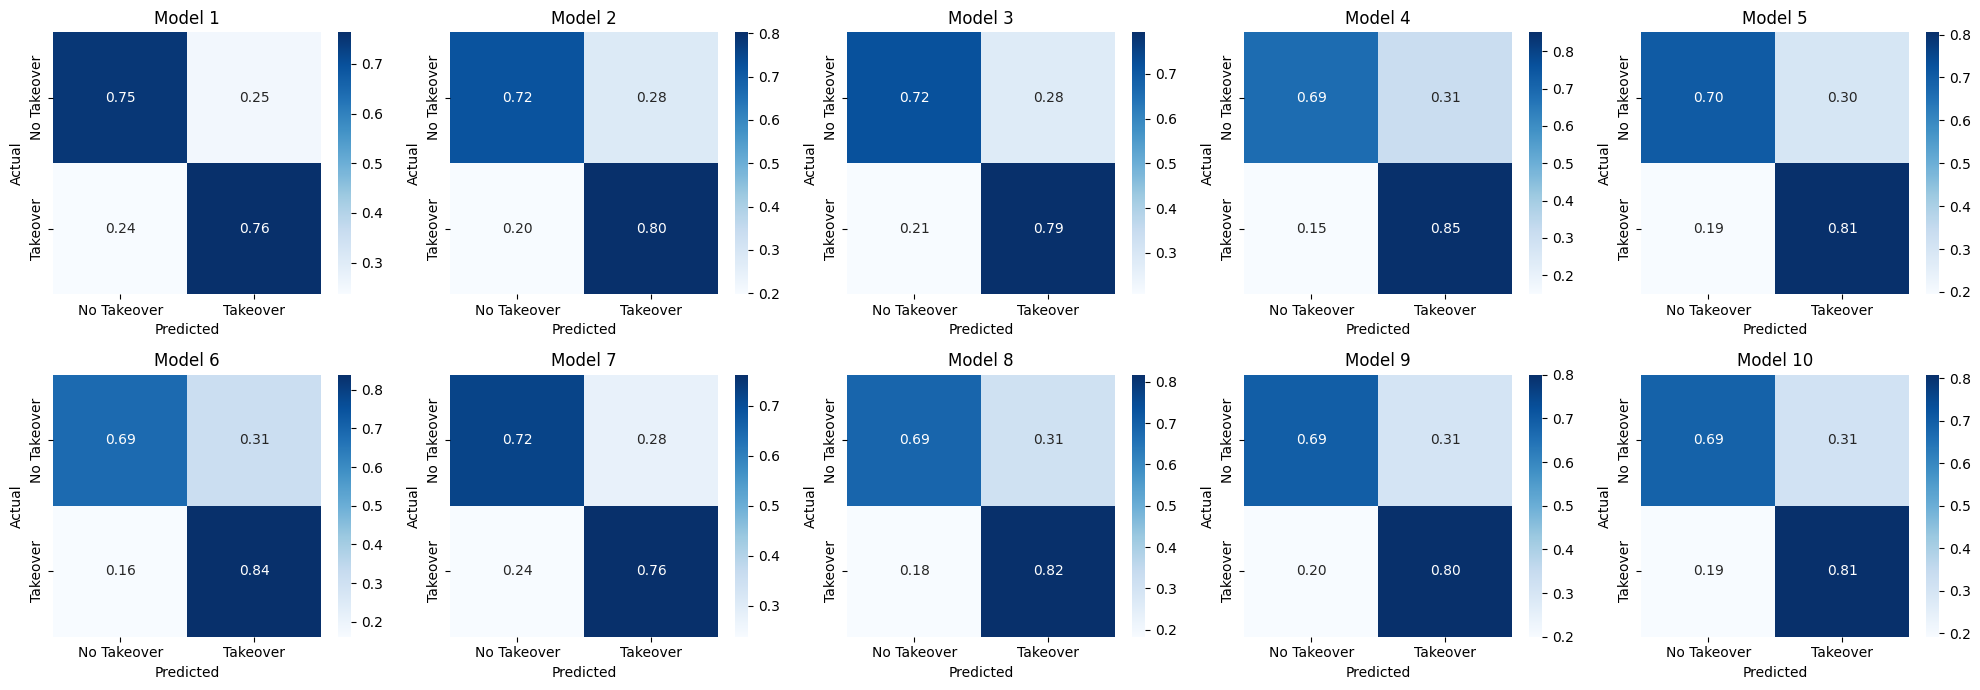

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(20, 7))

for i, ax in enumerate(axes.flatten()):
    model = top_10.iloc[i]
    tp = model["True Positives"]
    tn = model["True Negatives"]
    fp = model["False Positives"]
    fn = model["False Negatives"]
    confusion = np.array([[tn, fp], [fn, tp]])
    sns.heatmap(confusion / confusion.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2f', cmap='Blues', ax=ax)
    ax.set_title(f"Model {i + 1}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticklabels(["No Takeover", "Takeover"])
    ax.set_yticklabels(["No Takeover", "Takeover"])

plt.tight_layout()
plt.show()


In [7]:
top_10[
    [
        "Window Size",
        "Step Size",
        "Components Slow",
        "Mixtures Slow",
        "Components Fast",
        "Mixtures Fast",
        "Covariance Type",
        "Mean Accuracy",
        "Max Accuracy",
        "Precision",
        "Recall",
        "F1 Score",
    ]
]

,Window Size,Step Size,Components Slow,Mixtures Slow,Components Fast,Mixtures Fast,Covariance Type,Mean Accuracy,Max Accuracy,Precision,Recall,F1 Score
0,0.1,0.05,1,1,1,1,Full,0.674583,0.755208,0.739583,0.763441,0.751323
1,0.1,0.10,1,1,1,1,Diagonal,0.687240,0.755208,0.677083,0.802469,0.734463
2,0.1,0.05,1,1,1,1,Diagonal,0.685417,0.750000,0.677083,0.792683,0.730337
3,0.5,0.10,1,1,1,1,Diagonal,0.682240,0.744792,0.593750,0.850746,0.699387
4,0.5,0.50,1,1,1,1,Diagonal,0.670052,0.744792,0.645833,0.805195,0.716763
5,1.0,1.00,1,1,1,1,Full,0.649635,0.739583,0.593750,0.838235,0.695122
6,0.1,0.10,1,1,1,1,Full,0.677396,0.739583,0.697917,0.761364,0.728261
7,1.0,0.50,1,1,1,1,Diagonal,0.666198,0.734375,0.604167,0.816901,0.694611
8,0.5,0.50,1,1,1,1,Full,0.669375,0.734375,0.625000,0.800000,0.701754
9,1.0,1.00,1,1,1,1,Diagonal,0.666042,0.734375,0.614583,0.808219,0.698225


---

In [8]:
processed_physio_folder_path = "../Physiological Preprocessed/"

exp2_folder_path = processed_physio_folder_path + "Exp2"

In [9]:
exp2_takeover_times = pd.read_csv(
    "../AdVitam/Exp2/Preprocessed/Physio and Driving/timestamps_obstacles.csv"
)
exp2_takeover_times.iloc[:, 2:] = exp2_takeover_times.iloc[:, 2:].apply(pd.to_timedelta, unit="s")
exp2_takeover_times["subject_id"] = exp2_takeover_times["subject_id"].apply(
    lambda x: x.split("T")[0] + "T" + x.split("T")[1].zfill(2)
)
exp2_takeover_times["subject_id"] = exp2_takeover_times["subject_id"].astype(str)
exp2_takeover_times.drop(columns=["label_st"], inplace=True)
exp2_takeover_times.sort_values(by=["subject_id"], inplace=True)

for column in exp2_takeover_times.columns:
    if "TrigObs" in column:
        exp2_takeover_times = exp2_takeover_times.rename(
            columns={column: column.replace("TrigObs", "") + "TOR"}
        )
    elif "RepObs" in column:
        exp2_takeover_times = exp2_takeover_times.rename(
            columns={column: column.replace("RepObs", "Response")}
        )

exp2_takeover_times

,subject_id,DeerTOR,DetObsDeer,ResponseDeer,ConeTOR,DetObsCone,ResponseCone,FrogTOR,DetObsFrog,ResponseFrog,CanTOR,DetObsCan,ResponseCan,FA1TOR,DetObsFA1,ResponseFA1,FA2TOR,DetObsFA2,ResponseFA2
0,NST01,0 days 00:02:56.705100,0 days 00:02:59.093200,0 days 00:03:03.523800,0 days 00:06:56.214000,0 days 00:06:58.510900,0 days 00:06:58.690200,0 days 00:08:34.815700,0 days 00:08:38.845600,NaT,0 days 00:13:06.640800,0 days 00:13:12.859100,NaT,0 days 00:16:23.624000,NaT,NaT,0 days 00:18:02.245000,0 days 00:18:06.363000,NaT
2,NST03,0 days 00:13:35.204000,0 days 00:13:38.469300,0 days 00:13:39.824400,0 days 00:10:19.808800,0 days 00:10:21.816700,0 days 00:10:23.032200,0 days 00:04:19.471200,0 days 00:04:23.789000,NaT,0 days 00:17:07.400900,0 days 00:17:10.785900,NaT,0 days 00:06:18.340900,NaT,NaT,0 days 00:18:35.174900,0 days 00:18:42.818900,NaT
4,NST05,0 days 00:07:08.961300,0 days 00:07:10.742400,0 days 00:07:11.272600,0 days 00:12:23.166400,0 days 00:12:24.461700,0 days 00:12:38.273600,0 days 00:14:59.418600,0 days 00:15:00.724600,0 days 00:15:02.753600,0 days 00:04:28.071600,0 days 00:04:29.987500,0 days 00:04:31.402700,0 days 00:02:23.631400,0 days 00:02:24.742400,NaT,0 days 00:10:29.173600,0 days 00:10:30.421200,NaT
6,NST07,0 days 00:02:36.060300,0 days 00:02:39.121900,0 days 00:02:46.883100,0 days 00:06:11.856300,0 days 00:06:13.610700,0 days 00:06:15.090900,0 days 00:08:28.559300,0 days 00:08:31.772600,0 days 00:08:32.484500,0 days 00:12:00.085800,0 days 00:12:02.153100,0 days 00:12:02.817700,0 days 00:16:34.142400,0 days 00:16:37.435400,NaT,0 days 00:18:05.472400,0 days 00:18:08.195400,NaT
8,NST09,0 days 00:13:11.586070,0 days 00:13:13.970070,0 days 00:13:16.070470,0 days 00:08:18.826970,0 days 00:08:20.710570,0 days 00:08:22.473270,0 days 00:03:16.580170,0 days 00:03:21.515270,0 days 00:03:24.339770,0 days 00:15:36.305270,0 days 00:15:38.094270,0 days 00:15:39.460270,0 days 00:05:37.980670,0 days 00:05:52.104570,NaT,0 days 00:19:03.294270,0 days 00:19:07.322270,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,ST82,0 days 00:16:22.060600,0 days 00:16:25.019600,0 days 00:16:26.115600,0 days 00:11:27.337900,0 days 00:11:30.174000,0 days 00:11:31.206600,0 days 00:05:00.722700,0 days 00:05:05.274800,0 days 00:05:04.673200,0 days 00:02:09.414300,0 days 00:02:12.728300,NaT,0 days 00:08:01.118200,0 days 00:08:23.261900,NaT,0 days 00:13:10.705300,0 days 00:13:37.020600,NaT
83,ST84,0 days 00:13:08.533100,0 days 00:13:10.099000,0 days 00:13:15.842500,0 days 00:16:19.256299999,0 days 00:16:20.686300,0 days 00:16:22.944300,0 days 00:02:01.331000,0 days 00:02:02.753000,0 days 00:02:04.980400,0 days 00:08:02.602800,0 days 00:08:04.146900,0 days 00:05:04.680500,0 days 00:02:01.331000,0 days 00:02:02.753000,0 days 00:02:04.980400,0 days 00:05:00.889300,0 days 00:05:02.173200,0 days 00:05:04.680500
85,ST86,0 days 00:05:00.561600,0 days 00:05:02.025700,0 days 00:05:03.506499999,0 days 00:02:56.399600,0 days 00:02:57.203300,0 days 00:03:04.042600,0 days 00:13:40.438800,0 days 00:13:42.381800,0 days 00:13:45.033800,0 days 00:16:52.421300,0 days 00:16:54.161300,0 days 00:16:54.876300,0 days 00:08:11.486600,0 days 00:08:13.166100,NaT,0 days 00:10:30.702800,0 days 00:10:32.862900,NaT
87,ST88,0 days 00:17:33.644200,0 days 00:17:35.548200,0 days 00:17:38.642200,0 days 00:11:47.429500,0 days 00:11:49.730800,0 days 00:11:52.368200,0 days 00:05:03.127099999,0 days 00:05:07.203900,0 days 00:05:07.837400,0 days 00:02:22.286400,0 days 00:02:23.154300,NaT,0 days 00:08:03.736300,0 days 00:08:08.586700,NaT,0 days 00:13:32.521300,0 days 00:13:34.723000,NaT


### Create observations for takoever and driving segments

In [10]:
def collect_observations(exp2_folder_path, columns_to_drop, deviation_columns, columns_to_normalize, window_size, step_size):
    """
    Create the observations for the slow and fast takeover times.

    Args:
        phsyiological_data_dictionary (dict): A dictionary containing the segmented physiological data files.
        takeover_times (pd.DataFrame): A DataFrame containing the takeover times.
        driver_demographic_data (pd.DataFrame): A DataFrame containing the driver demographic data.
        window_length (int): The length of the window in minutes.
        window_step (int): The step size for the window
        step_sizes (list): A list of step sizes for the window.
        tot (str): The threshold for the takeover time.

    Returns:
        list: A list of observations for the slow takeover times.
        list: A list of observations for the fast takeover times.
    """

    driving_observations_data = []
    takeover_observations_data = []

    # Exp2
    phsyiological_data_dictionary = {}
    for file in os.listdir(exp2_folder_path):
        # Split the file name into the participant and period
        f = file.split("_")
        participant = f[0]
        period = f[1].split(".")[0]

        if period != "baseline" and period != "driving":
            continue

        # Baseline Data
        if participant not in phsyiological_data_dictionary:
            phsyiological_data_dictionary[participant] = {}
            phsyiological_data_dictionary[participant][period] = pd.read_csv(
                exp2_folder_path + "/" + file
            )

        # Physiological data
        else:
            phsyiological_data_dictionary[participant][period] = pd.read_csv(
                exp2_folder_path + "/" + file
            )

            # Process the physiological data
            baseline_physio = phsyiological_data_dictionary[participant]["baseline"].copy()
            del phsyiological_data_dictionary[participant]["baseline"]
            baseline_physio.Time = pd.to_timedelta(baseline_physio.Time)
            baseline_physio = baseline_physio.set_index("Time")

            experiment_physio = phsyiological_data_dictionary[participant]["driving"].copy()
            del phsyiological_data_dictionary[participant]["driving"]
            experiment_physio.Time = pd.to_timedelta(experiment_physio.Time)
            experiment_physio = experiment_physio.set_index("Time")

            # print(participant)

            # Calculate the deviation from the baseline mean
            baseline_physio_mean = baseline_physio[deviation_columns].mean()
            baseline_deviation = experiment_physio[deviation_columns] - baseline_physio_mean
            experiment_physio.drop(
                columns=deviation_columns,
                inplace=True,
            )
            experiment_physio = pd.concat([baseline_deviation, experiment_physio], axis=1)
            experiment_physio.drop(columns=columns_to_drop, inplace=True)

            # calculate the hrv of the baseline
            baseline_hrv = nk.hrv(baseline_physio["ECG_R_Peaks"], sampling_rate=1000)

            # Obstacle Trigger Times
            participant_takeover_times = exp2_takeover_times[
                exp2_takeover_times["subject_id"] == participant
            ].copy()
            participant_takeover_times.iloc[:, 1:] = participant_takeover_times.iloc[:, 1:].apply(
                pd.to_timedelta, args=("s",), errors="coerce"
            )

            participant_obstacle_data = pd.DataFrame()
            participant_obstacle_data_length = 0

            obstacles = ["Deer", "Cone", "Frog", "Can"]
            for obstacle in obstacles:
                # print(obstacle)
                # Participant Takeover Time for the Obstacle

                # Obstacle Trigger Time
                obstacle_trigger_time = pd.to_timedelta(
                    participant_takeover_times[f"{obstacle}TOR"].values[0], unit="s"
                )
                minute_before_obstacle = obstacle_trigger_time - pd.Timedelta(seconds=60)

                # If the obstacle trigger time is null, skip the obstacle
                if pd.isnull(obstacle_trigger_time):
                    continue
                if pd.isnull(minute_before_obstacle):
                    continue

                # Observations 1 minute before and after the obstacle
                driving_observations_before_obstacle = experiment_physio.loc[
                    minute_before_obstacle - pd.Timedelta(seconds=4) : minute_before_obstacle
                ].copy()
                driving_observations_after_obstacle = experiment_physio.loc[
                    minute_before_obstacle : minute_before_obstacle + pd.Timedelta(seconds=8)
                ].copy()

                # Observations 3 seconds before and after the obstacle
                takeover_observations_before_obstacle = experiment_physio.loc[
                    obstacle_trigger_time - pd.Timedelta(seconds=4) : obstacle_trigger_time
                ].copy()
                takeover_observations_after_obstacle = experiment_physio.loc[
                    obstacle_trigger_time : obstacle_trigger_time + pd.Timedelta(seconds=8)
                ].copy()

                # Debugging statements
                # print(f"Participant: {participant}, Obstacle: {obstacle}")
                # print(f"Driving observations before obstacle: {len(driving_observations_before_obstacle)}")
                # print(f"Driving observations after obstacle: {len(driving_observations_after_obstacle)}")
                # print(f"Takeover observations before obstacle: {len(takeover_observations_before_obstacle)}")
                # print(f"Takeover observations after obstacle: {len(takeover_observations_after_obstacle)}")

                # Check if the last observation of before obstacle is the same as the first observation of after obstacle
                if (
                    len(driving_observations_before_obstacle) > 0
                    and len(driving_observations_after_obstacle) > 0
                    and driving_observations_before_obstacle.tail(1).index
                    == driving_observations_after_obstacle.head(1).index
                ):
                    # drop the first observation of after obstacle
                    driving_observations_after_obstacle = driving_observations_after_obstacle.iloc[
                        1:
                    ]

                if (
                    len(takeover_observations_before_obstacle) > 0
                    and len(takeover_observations_after_obstacle) > 0
                    and takeover_observations_before_obstacle.tail(1).index
                    == takeover_observations_after_obstacle.head(1).index
                ):
                    # drop the first observation of after obstacle
                    takeover_observations_after_obstacle = (
                        takeover_observations_after_obstacle.iloc[1:]
                    )
                    # print("dropped")
                    # print("new length", len(takeover_observations_after_obstacle))

                # Check if the length of the observations is 3000
                if len(driving_observations_before_obstacle) > 4000:
                    # drop the first n rows
                    n = len(driving_observations_before_obstacle) - 4000
                    driving_observations_before_obstacle = (
                        driving_observations_before_obstacle.iloc[n:]
                    )
                elif len(driving_observations_before_obstacle) < 4000:
                    continue

                if len(driving_observations_after_obstacle) > 8000:
                    # drop the last n rows
                    driving_observations_after_obstacle = driving_observations_after_obstacle.iloc[
                        :8000
                    ]
                elif len(driving_observations_after_obstacle) < 8000:
                    continue

                if len(takeover_observations_before_obstacle) > 4000:
                    # drop the first n rows
                    n = len(takeover_observations_before_obstacle) - 4000
                    takeover_observations_before_obstacle = (
                        takeover_observations_before_obstacle.iloc[n:]
                    )
                elif len(takeover_observations_before_obstacle) < 4000:
                    continue

                if len(takeover_observations_after_obstacle) > 8000:
                    # drop the last n rows
                    takeover_observations_after_obstacle = (
                        takeover_observations_after_obstacle.iloc[:8000]
                    )
                elif len(takeover_observations_after_obstacle) < 8000:
                    continue

                # HRV
                driving_hrv_before_obstacle = nk.hrv_time(
                    driving_observations_before_obstacle["ECG_R_Peaks"], sampling_rate=1000
                )
                driving_hrv_after_obstacle = nk.hrv_time(
                    driving_observations_after_obstacle["ECG_R_Peaks"], sampling_rate=1000
                )

                takeover_hrv_before_obstacle = nk.hrv_time(
                    takeover_observations_before_obstacle["ECG_R_Peaks"], sampling_rate=1000
                )
                takeover_hrv_after_obstacle = nk.hrv_time(
                    takeover_observations_after_obstacle["ECG_R_Peaks"], sampling_rate=1000
                )

                if "ECG_R_Peaks" in columns_to_drop:
                    # drop the ecg_r_peaks from the observations
                    driving_observations_before_obstacle.drop(columns=["ECG_R_Peaks"], inplace=True)
                    driving_observations_after_obstacle.drop(columns=["ECG_R_Peaks"], inplace=True)

                    takeover_observations_before_obstacle.drop(columns=["ECG_R_Peaks"], inplace=True)
                    takeover_observations_after_obstacle.drop(columns=["ECG_R_Peaks"], inplace=True)

                # add the hrv features to the observations
                for column in [
                    "HRV_MeanNN",
                    "HRV_SDNN",
                    "HRV_RMSSD",
                    "HRV_CVSD",
                    "HRV_MedianNN",
                    "HRV_MadNN",
                    "HRV_MCVNN",
                    "HRV_IQRNN",
                    "HRV_SDRMSSD",
                    "HRV_Prc20NN",
                    "HRV_Prc80NN",
                    "HRV_pNN50",
                    "HRV_pNN20",
                    "HRV_MinNN",
                    "HRV_MaxNN",
                    "HRV_HTI",
                    "HRV_TINN",
                ]:
                    driving_observations_before_obstacle = (
                        driving_observations_before_obstacle.assign(
                            **{
                                column: driving_hrv_before_obstacle[column].values[0]
                                - baseline_hrv[column].values[0]
                            }
                        )
                    )
                    driving_observations_after_obstacle = (
                        driving_observations_after_obstacle.assign(
                            **{
                                column: driving_hrv_after_obstacle[column].values[0]
                                - baseline_hrv[column].values[0]
                            }
                        )
                    )
                    takeover_observations_before_obstacle = (
                        takeover_observations_before_obstacle.assign(
                            **{
                                column: takeover_hrv_before_obstacle[column].values[0]
                                - baseline_hrv[column].values[0]
                            }
                        )
                    )
                    takeover_observations_after_obstacle = (
                        takeover_observations_after_obstacle.assign(
                            **{
                                column: takeover_hrv_after_obstacle[column].values[0]
                                - baseline_hrv[column].values[0]
                            }
                        )
                    )

                # Combine the observations
                driving_observations = pd.concat(
                    [driving_observations_before_obstacle, driving_observations_after_obstacle]
                )
                takeover_observations = pd.concat(
                    [takeover_observations_before_obstacle, takeover_observations_after_obstacle]
                )

                # sliding window with step size
                resampled_data = pd.DataFrame()
                for column in driving_observations.columns:
                    if column in columns_to_normalize:
                        resampled_data[column] = (
                            driving_observations[column].rolling(window_size).mean()
                        )
                        resampled_data[column] = resampled_data[column].resample(step_size).mean()
                        resampled_data.dropna(inplace=True)
                        # resampled_data[column] = resampled_data[column].interpolate(method="ffill")
                    else:
                        resampled_data[column] = (
                            driving_observations[column].rolling(window_size).max()
                        )
                        resampled_data[column] = resampled_data[column].resample(step_size).max()
                        resampled_data.dropna(inplace=True)
                        # resampled_data[column] = resampled_data[column].interpolate(method="ffill")
                driving_observations = resampled_data

                resampled_data = pd.DataFrame()
                for column in takeover_observations.columns:
                    if column in columns_to_normalize:
                        resampled_data[column] = (
                            takeover_observations[column].rolling(window_size).mean()
                        )
                        resampled_data[column] = resampled_data[column].resample(step_size).mean()
                        resampled_data.dropna(inplace=True)
                        # resampled_data[column] = resampled_data[column].interpolate(method="ffill")
                    else:
                        resampled_data[column] = (
                            takeover_observations[column].rolling(window_size).max()
                        )
                        resampled_data[column] = resampled_data[column].resample(step_size).max()
                        resampled_data.dropna(inplace=True)
                        # resampled_data[column] = resampled_data[column].interpolate(method="ffill")
                takeover_observations = resampled_data

                # add the tot to the observations
                driving_observations = driving_observations.assign(takeover=0)
                takeover_observations = takeover_observations.assign(takeover=1)

                if participant_obstacle_data_length == 0:
                    participant_obstacle_data_length = len(driving_observations)

                if (
                    len(driving_observations)
                    != len(takeover_observations)
                    != participant_obstacle_data_length
                ):
                    print(f"Participant: {participant}, Obstacle: {obstacle}, Lengths do not match")
                    continue

                # add the observations to the participant obstacle data
                participant_obstacle_data = pd.concat(
                    [participant_obstacle_data, driving_observations, takeover_observations]
                )

            # After looping through the obstacles
            # Standardize the data
            time = participant_obstacle_data.index
            columns = participant_obstacle_data.columns
            scaler = StandardScaler()
            participant_obstacle_data[columns_to_normalize] = scaler.fit_transform(
                participant_obstacle_data[columns_to_normalize]
            )
            participant_obstacle_data = pd.DataFrame(participant_obstacle_data, columns=columns)
            participant_obstacle_data["Time"] = time
            participant_obstacle_data = participant_obstacle_data.set_index("Time")

            # seperate the data into slow and fast takeovers
            while len(participant_obstacle_data) > 0:
                # get the first observations
                observations = participant_obstacle_data.iloc[:participant_obstacle_data_length]
                participant_obstacle_data = participant_obstacle_data.iloc[
                    participant_obstacle_data_length:
                ]

                # takover from the observations
                takeover = observations["takeover"].values[0]
                observations.drop(columns=["takeover"], inplace=True)

                if takeover == 0:
                    driving_observations_data.append(observations)
                else:
                    takeover_observations_data.append(observations)

    return driving_observations_data, takeover_observations_data

In [11]:
window_size = "100ms"
step_size = "50ms"

In [12]:
columns_to_drop = [
        "CH1",
        "CH2",
        "CH3",
        "ECG_Raw",
        "ECG_Clean",
        "ECG_Quality",
        "ECG_R_Onsets",
        "ECG_R_Offsets",
        "ECG_P_Peaks",
        "ECG_P_Onsets",
        "ECG_P_Offsets",
        "ECG_Q_Peaks",
        "ECG_S_Peaks",
        "ECG_T_Peaks",
        "ECG_T_Onsets",
        "ECG_T_Offsets",
        "ECG_Phase_Atrial",
        "ECG_Phase_Completion_Atrial",
        "ECG_Phase_Ventricular",
        "ECG_Phase_Completion_Ventricular",
        "RSP_Raw",
        "RSP_Clean",
        "RSP_Peaks",
        "RSP_Troughs",
        "RSP_Amplitude",
        "RSP_Phase",
        "RSP_Phase_Completion",
        "RSP_RVT",
        "EDA_Raw",
        "EDA_Clean",
        "EDA_Tonic",
        "EDA_Phasic",
        "SCR_Onsets",
        "SCR_Height",
        "SCR_Recovery",
        "RSA_P2T",
        "RSA_Gates",
]

In [13]:
deviation_columns = ["ECG_Rate", "RSP_Rate"]

In [14]:
columns_to_normalize = [
    "ECG_Rate",
    "RSP_Rate",
    "HRV_MeanNN",
    "HRV_SDNN",
    "HRV_RMSSD",
    "HRV_CVSD",
    "HRV_MedianNN",
    "HRV_MadNN",
    "HRV_MCVNN",
    "HRV_IQRNN",
    "HRV_SDRMSSD",
    "HRV_Prc20NN",
    "HRV_Prc80NN",
    "HRV_pNN50",
    "HRV_pNN20",
    "HRV_MinNN",
    "HRV_MaxNN",
    "HRV_HTI",
    "HRV_TINN",
]

In [15]:
driving_observations, takeover_observations = collect_observations(
    exp2_folder_path,
    columns_to_drop,
    deviation_columns,
    columns_to_normalize,
    window_size,
    step_size,
)

/Users/joelmiller/Library/Python/3.9/lib/python/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/joelmiller/Library/Python/3.9/lib/python/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/joelmiller/Library/Python/3.9/lib/python/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/joelmiller/Library/Python/3.9/lib/python/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/joelmiller/Library/Python/3.9/lib/python/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis

Participant: NST49, Obstacle: Cone, Lengths do not match


/Users/joelmiller/Library/Python/3.9/lib/python/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [16]:
n_components_driving, n_mix_driving, n_components_takeover, n_mix_takeover = 1, 1, 1, 1
covariance_type = "full"

In [17]:
iterations = 500

accuracies = []
true_positives_list = []
false_positives_list = []
true_negatives_list = []
false_negatives_list = []

best_model = None

for i in range(iterations):
    if i % 10 == 0:
        print(f"Iteration: {i}")

    # split the data
    driving_observations_train, driving_observations_test = train_test_split(
        driving_observations, test_size=0.3
    )
    takeover_observations_train, takeover_observations_test = train_test_split(
        takeover_observations, test_size=0.3
    )

    # concatenate the observations
    X_driving = None
    X_driving_lengths = []
    for data in driving_observations_train:
        if X_driving is None:
            X_driving = data.values
        else:
            X_driving = np.concatenate((X_driving, data.values))
        X_driving_lengths.append(len(data))

    X_takeover = None
    X_takeover_lengths = []
    for data in takeover_observations_train:
        if X_takeover is None:
            X_takeover = data.values
        else:
            X_takeover = np.concatenate((X_takeover, data.values))
        X_takeover_lengths.append(len(data))

    # initialize and fit the models
    driving_model = hmm.GMMHMM(
        n_components=n_components_driving, n_mix=n_mix_driving, covariance_type=covariance_type
    )
    takeover_model = hmm.GMMHMM(
        n_components=n_components_takeover,
        n_mix=n_mix_takeover,
        covariance_type=covariance_type,
    )

    # fit the models
    driving_model.fit(X_driving, X_driving_lengths)
    takeover_model.fit(X_takeover, X_takeover_lengths)

    # score the models
    accuracy = 0
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    for _, observation in enumerate(driving_observations_test):
        observation = observation.values

        if driving_model.score(observation) > takeover_model.score(observation):
            accuracy += 1
            tn += 1
        else:
            fn += 1

    for _, observation in enumerate(takeover_observations_test):
        observation = observation.values

        if takeover_model.score(observation) > driving_model.score(observation):
            accuracy += 1
            tp += 1
        else:
            fp += 1

    accuracy = accuracy / (len(driving_observations_test) + len(takeover_observations_test))
    accuracies.append(accuracy)

    true_positives_list.append(tp)
    false_positives_list.append(fp)
    true_negatives_list.append(tn)
    false_negatives_list.append(fn)

    if best_model is None or accuracy > best_model["Max Accuracy"]:
        best_model = {
            "Mean Accuracy": np.mean(accuracies),
            "Max Accuracy": accuracy,
            "Min Accuracy": np.min(accuracies),
            "Standard Deviation": np.std(accuracies),
            "True Positives": tp,
            "False Positives": fp,
            "True Negatives": tn,
            "False Negatives": fn,
            "Driving Model": driving_model,
            "Takeover Model": takeover_model,
        }

    if i % 10 == 0:
        print(f"Accuracy: {accuracy}")
        print(f"True Positives: {tp}")
        print(f"False Positives: {fp}")
        print(f"True Negatives: {tn}")
        print(f"False Negatives: {fn}")

Iteration: 0
Accuracy: 0.6510416666666666
True Positives: 43
False Positives: 53
True Negatives: 82
False Negatives: 14
Iteration: 10
Accuracy: 0.703125
True Positives: 56
False Positives: 40
True Negatives: 79
False Negatives: 17
Iteration: 20
Accuracy: 0.671875
True Positives: 52
False Positives: 44
True Negatives: 77
False Negatives: 19
Iteration: 30
Accuracy: 0.640625
True Positives: 46
False Positives: 50
True Negatives: 77
False Negatives: 19
Iteration: 40
Accuracy: 0.6510416666666666
True Positives: 55
False Positives: 41
True Negatives: 70
False Negatives: 26
Iteration: 50
Accuracy: 0.6354166666666666
True Positives: 43
False Positives: 53
True Negatives: 79
False Negatives: 17
Iteration: 60
Accuracy: 0.671875
True Positives: 57
False Positives: 39
True Negatives: 72
False Negatives: 24
Iteration: 70
Accuracy: 0.6614583333333334
True Positives: 50
False Positives: 46
True Negatives: 77
False Negatives: 19
Iteration: 80
Accuracy: 0.6302083333333334
True Positives: 54
False Posit

In [101]:
# Look at the best models
driving_model = best_model["Driving Model"]
takeover_model = best_model["Takeover Model"]

In [102]:
# features
features = driving_observations[0].columns


In [ ]:
# explore driving model
driving_model_means = driving_model.means_
takeover_model_means = takeover_model.means_

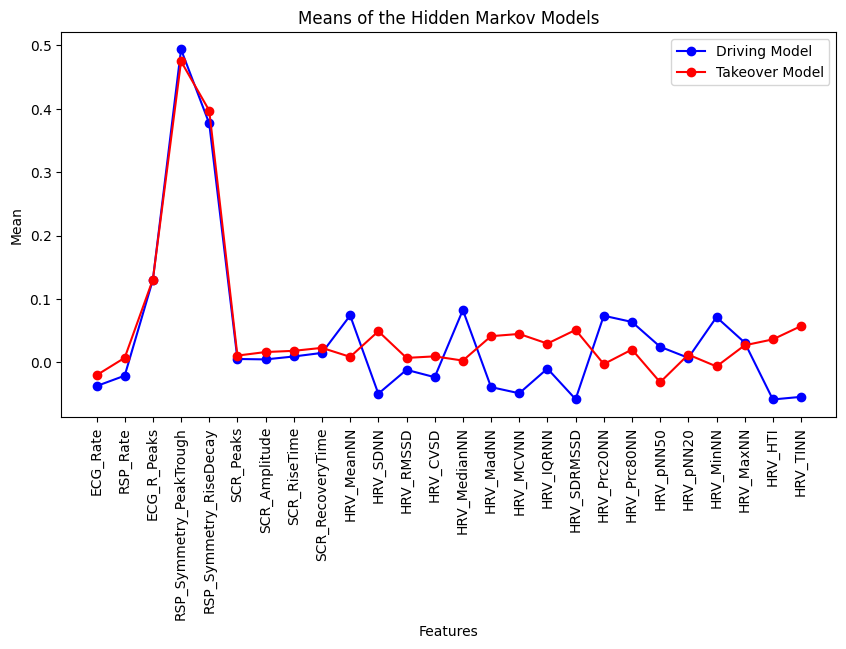

In [105]:
# plot the means
plt.figure(figsize=(10, 5))
plt.plot(range(len(features)), driving_model_means[0][0], '-o', color="blue", label="Driving Model")
plt.plot(range(len(features)), takeover_model_means[0][0], '-o', color="red", label="Takeover Model")
plt.title("Means of the Hidden Markov Models")
plt.xlabel("Features")
plt.ylabel("Mean")
plt.xticks(range(len(features)), features, rotation=90)
plt.legend()
plt.show()

In [146]:
# Covariance parameters for each state. Only one component so covariance matrix is of size (1, n_features, n_features)
driving_model_covars = driving_model.covars_[0][0]
takeover_model_covars = takeover_model.covars_[0][0]

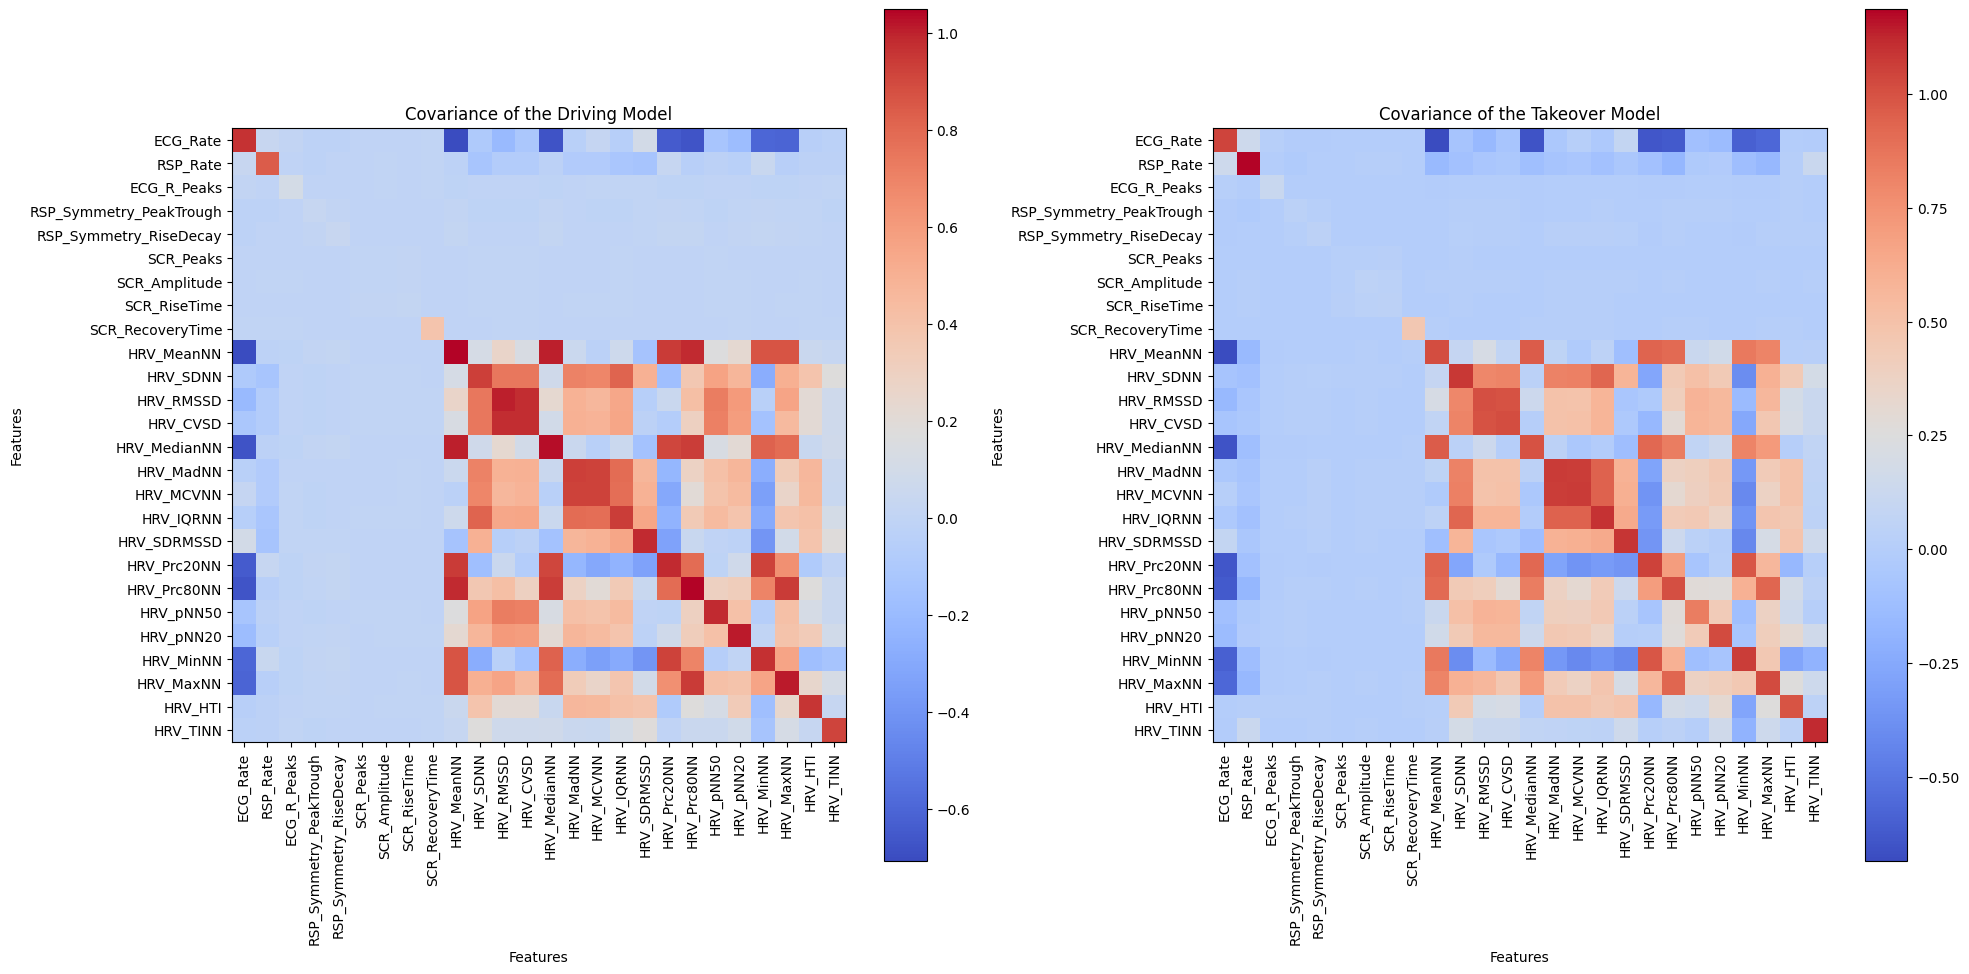

In [159]:
# plot the covariance
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot covariance of the Driving Model
axes[0].imshow(driving_model_covars, cmap='coolwarm', interpolation='none')
axes[0].set_title("Covariance of the Driving Model")
axes[0].set_xlabel("Features")
axes[0].set_xticks(range(len(features)))
axes[0].set_xticklabels(features, rotation=90)
axes[0].set_ylabel("Features")
axes[0].set_yticks(range(len(features)))
axes[0].set_yticklabels(features)
fig.colorbar(axes[0].images[0], ax=axes[0])

# Plot covariance of the Takeover Model
axes[1].imshow(takeover_model_covars, cmap='coolwarm', interpolation='none')
axes[1].set_title("Covariance of the Takeover Model")
axes[1].set_xlabel("Features")
axes[1].set_xticks(range(len(features)))
axes[1].set_xticklabels(features, rotation=90)
axes[1].set_ylabel("Features")
axes[1].set_yticks(range(len(features)))
axes[1].set_yticklabels(features)
fig.colorbar(axes[1].images[0], ax=axes[1])

plt.tight_layout()
plt.show()

In [152]:
# standard deviations
driving_model_std = np.sqrt(np.diagonal(driving_model.covars_, axis1=2, axis2=3))
takeover_model_std = np.sqrt(np.diagonal(takeover_model.covars_, axis1=2, axis2=3))

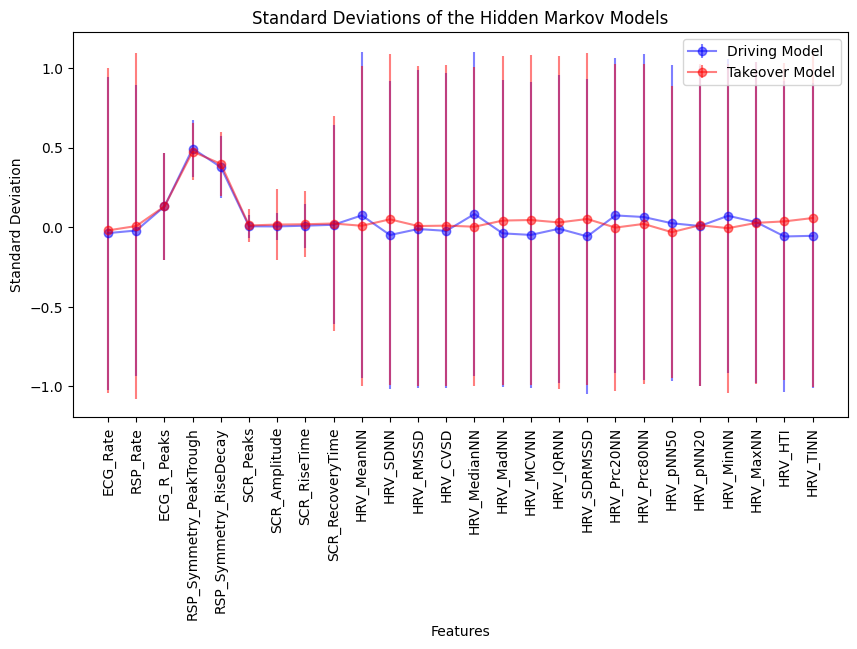

In [154]:
# plot the means with standard deviations
plt.figure(figsize=(10, 5))
plt.errorbar(range(len(features)), driving_model_means[0][0], yerr=driving_model_std[0][0], fmt='-o', color="blue", label="Driving Model", alpha=0.5)
plt.errorbar(range(len(features)), takeover_model_means[0][0], yerr=takeover_model_std[0][0], fmt='-o', color="red", label="Takeover Model", alpha=0.5)
plt.title("Standard Deviations of the Hidden Markov Models")
plt.xlabel("Features")
plt.ylabel("Standard Deviation")
plt.xticks(range(len(features)), features, rotation=90)
plt.legend()
plt.show()